<a href="https://colab.research.google.com/github/parsa-abbasi/Sentiment-Analysis/blob/master/Multiclass-Classification/ML_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

## Install required libraries

In [2]:
!pip install matplotlib==3.1.0

In [3]:
!pip install hazm
!pip install stopwords_guilannlp

## Import Libraries

In [ ]:
# General
import numpy as np
import pandas as pd
import codecs
from google.colab import files
# sklearn
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
# Measuring metrics
from sklearn.metrics import f1_score

# Upload dataset files

Upload dataset files to colab environment

In [6]:
uploaded = files.upload()

Saving balanced.csv to balanced.csv
Saving original.csv to original.csv
Saving test.csv to test.csv
Saving translation.csv to translation.csv



# Import & Analyze Dataset

In [ ]:
test = pd.read_csv('test.csv', index_col=None, header=None, encoding="utf-8")

In [ ]:
x_test = test[0]
y_test = test[1]

In [9]:
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


In [ ]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [ ]:
original = pd.read_csv('original.csv', index_col=None, header=None, encoding="utf-8")
balanced = pd.read_csv('balanced.csv', index_col=None, header=None, encoding="utf-8")
translation = pd.read_csv('translation.csv', index_col=None, header=None, encoding="utf-8")

In [ ]:
selected_dataset = translation

In [ ]:
selected_dataset = selected_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
x_train = selected_dataset[0]
y_train = selected_dataset[1]

In [162]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (14046,)
Number of training label:  (14046,)


In [ ]:
# Convert dataframes to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [164]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{1: 4000, 0: 4000, 2: 3856, -1: 1874, -2: 316}


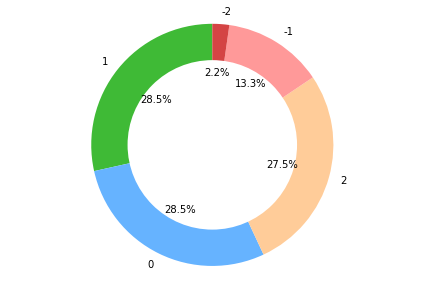

In [165]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()

In [ ]:
# Decomment following line if you want to download dataset figure
# files.download('distribution.png')

# Preprocess

In [ ]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

In [ ]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [ ]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

# Machine Learning Algorithms

In [ ]:
# Make stop word set
stop_set = stopwords_output("Persian", "set")


# When building the vocabulary ignore terms that have a document frequency strictly lower than
# the given threshold. This value is also called cut-off in the literature.
min_df = 1


# Tokenize function used in Vectorizer
def tokenize(text):
    return word_tokenize(text)

## Naive Bayes

In [171]:
# (Multinomial) Naive Bayes Model
naive_bayes = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                              analyzer='word', ngram_range=(1, 2), min_df=min_df, lowercase=False)),
                     ('tfidf', TfidfTransformer(sublinear_tf=True)),
                     ('clf', MultinomialNB())])
naive_bayes = naive_bayes.fit(x_train, y_train)
naive_score = naive_bayes.score(x_test, y_test)
print('Naive Bayes Model: ', naive_score)
predict_nb = naive_bayes.predict(x_test)

Naive Bayes Model:  0.5846817691477886


## Support Vector Machine

In [212]:
# Linear Support Vector Machine Model
svm = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                                         analyzer='word', ngram_range=(1, 2),
                                                         min_df=min_df, lowercase=False)),
                                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                                ('clf-svm', LinearSVC(loss='hinge', penalty='l2',
                                                      max_iter=5))])

svm = svm.fit(x_train, y_train)
linear_svc_score = svm.score(x_test, y_test)
print('Linear SVC Model: ', linear_svc_score)
predict_svm = svm.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear SVC Model:  0.6903991370010788


## Stochastic Gradient Descent

In [213]:
# SGD (Stochastic Gradient Descent) Model
sgd = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                                  analyzer='word', ngram_range=(1, 2), min_df=min_df, lowercase=False)),
                         ('tfidf', TfidfTransformer(sublinear_tf=True)),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                                   alpha=1e-3, max_iter=5))])
sgd = sgd.fit(x_train, y_train)
sgd_score = sgd.score(x_test, y_test)
print('SGD Model: ', sgd_score)
predict_sgd = sgd.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD Model:  0.6240560949298813


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1, 2, -2, -1])
np.set_printoptions(precision=2)

In [ ]:
y_test = y_test.astype(int)
predict_nb = predict_nb.astype(int)
predict_svm = predict_svm.astype(int)
predict_sgd = predict_sgd.astype(int)

Confusion matrix, without normalization
[[  0   0   1   3   8]
 [  0  15  30 103  36]
 [  0   3 410 231  99]
 [  0   0  49 348 164]
 [  0   0   3  40 311]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.   0.   0.08 0.25 0.67]
 [0.   0.08 0.16 0.56 0.2 ]
 [0.   0.   0.55 0.31 0.13]
 [0.   0.   0.09 0.62 0.29]
 [0.   0.   0.01 0.11 0.88]]
AxesImage(54,36;334.8x217.44)


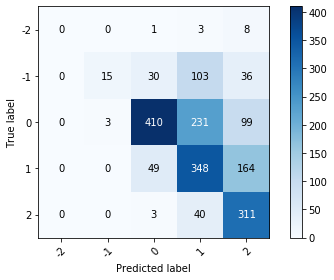

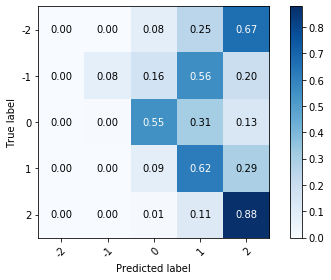

In [216]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_nb, classes=class_names)
# plt.savefig('cm-nb.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_nb, classes=class_names, normalize=True)
# plt.savefig('cm-nb-normalized.png')
plt.show()

Confusion matrix, without normalization
[[  7   1   1   0   3]
 [  5 129  19  22   9]
 [  3  71 514 107  48]
 [  2  36  79 309 135]
 [  0   2   1  30 321]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.58 0.08 0.08 0.   0.25]
 [0.03 0.7  0.1  0.12 0.05]
 [0.   0.1  0.69 0.14 0.06]
 [0.   0.06 0.14 0.55 0.24]
 [0.   0.01 0.   0.08 0.91]]
AxesImage(54,36;334.8x217.44)


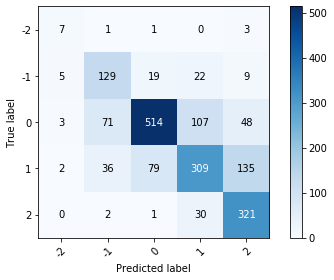

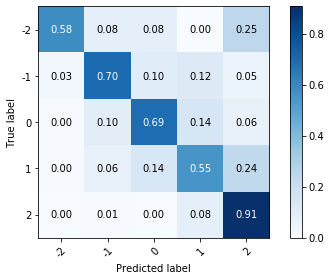

In [217]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_svm, classes=class_names)
# plt.savefig('cm-svm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_svm, classes=class_names, normalize=True)
# plt.savefig('cm-svm-normalized.png')
plt.show()

Confusion matrix, without normalization
[[  4   2   1   0   5]
 [  4  99  23  23  35]
 [  1  52 483  88 119]
 [  0  24  82 225 230]
 [  0   0   3   5 346]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.33 0.17 0.08 0.   0.42]
 [0.02 0.54 0.12 0.12 0.19]
 [0.   0.07 0.65 0.12 0.16]
 [0.   0.04 0.15 0.4  0.41]
 [0.   0.   0.01 0.01 0.98]]
AxesImage(54,36;334.8x217.44)


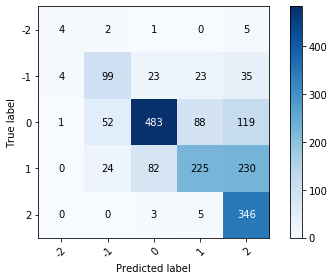

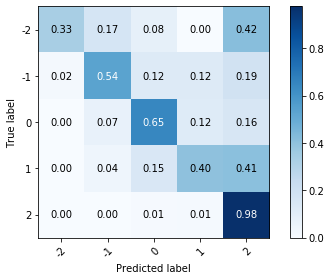

In [218]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predict_sgd, classes=class_names)
# plt.savefig('cm-sgd.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predict_sgd, classes=class_names, normalize=True)
# plt.savefig('cm-sgd-normalized.png')
plt.show()

## F1 Score

In [219]:
print("F1 score of NB model:")
f1_score(y_test, predict_nb, average='weighted')

F1 score of NB model:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5665625287115312

In [220]:
print("F1 score of SVM model:")
f1_score(y_test, predict_svm, average='weighted')

F1 score of SVM model:


0.6898796924126428

In [221]:
print("F1 score of SGD model:")
f1_score(y_test, predict_sgd, average='weighted')

F1 score of SGD model:


0.6191738209375972